** Google Code Lab, TensorFlow and deep learning without a PhD **

https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/#0

Let's first load the MNIST data.

In [1]:
%matplotlib notebook
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
print("Tensorflow version " + tf.__version__)
tf.set_random_seed(0)

# Download images and labels into mnist.test (10K images+labels) and mnist.train (60K images+labels)
mnist = mnist_data.read_data_sets("data", one_hot=True, reshape=False, validation_size=0)

# input X: 28x28 grayscale images, the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
# correct answers will go here
Y_ = tf.placeholder(tf.float32, [None, 10])

Tensorflow version 1.0.1
Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


Let's visualize some of the MNIST training data.

<IPython.core.display.Javascript object>


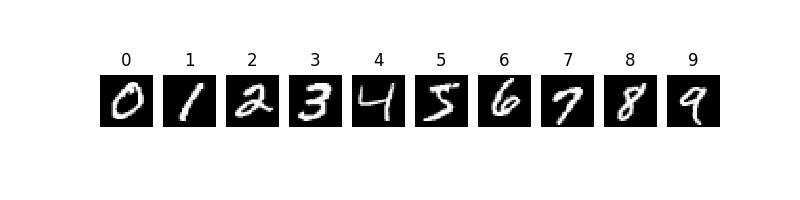

In [2]:
# Function for visualizing MNIST data, returns a list of image axes
def plot_mnist(data, classes, correct=None):
    
    im = []
    for i in range(10):
        idxs = (classes == i)
        if correct is not None:
            idxs *= correct
            
        plt.subplot(1,10,i+1)
        # Show one exammple from each class of number
        im.append(plt.imshow(data[idxs][0].reshape(28,28), cmap='gray', animated=True))
        plt.title(i)
        plt.axis('off')
    return im

plt.figure(1,figsize=(8,2))
classes = np.argmax(mnist.train.labels, axis=1)
_ = plot_mnist(mnist.train.images, classes)

Let's define our neural network. We will start with a 1-layer fully-connected network. The base MNIST network can achieve > 92% accuracy on the test data.

In [3]:
# neural network with 1 layer of 10 softmax neurons
#
# · · · · · · · · · ·       (input data, flattened pixels)       X [batch, 784]        # 784 = 28 * 28
# \x/x\x/x\x/x\x/x\x/    -- fully connected layer (softmax)      W [784, 10]     b[10]
#   · · · · · · · ·                                              Y [batch, 10]

# The model is:
#
# Y = softmax( X * W + b)
#              X: matrix for 100 grayscale images of 28x28 pixels, flattened (there are 100 images in a mini-batch)
#              W: weight matrix with 784 lines and 10 columns
#              b: bias vector with 10 dimensions
#              +: add with broadcasting: adds the vector to each line of the matrix (numpy)
#              softmax(matrix) applies softmax on each line
#              softmax(line) applies an exp to each value then divides by the norm of the resulting line
#              Y: output matrix with 100 lines and 10 columns

# weights W[784, 10]   784=28*28
W = tf.Variable(tf.zeros([784, 10]))
# biases b[10]
b = tf.Variable(tf.zeros([10]))

# flatten the images into a single line of pixels
# -1 in the shape definition means "the only possible dimension that will preserve the number of elements"
XX = tf.reshape(X, [-1, 784])

# The model
Y = tf.nn.softmax(tf.matmul(XX, W) + b)

# loss function: cross-entropy = - sum( Y_i * log(Yi) )
#                           Y: the computed output vector
#                           Y_: the desired output vector

# cross-entropy
# log takes the log of each element, * multiplies the tensors element by element
# reduce_mean will add all the components in the tensor
# so here we end up with the total cross-entropy for all images in the batch
cross_entropy = -tf.reduce_mean(Y_ * tf.log(Y)) * 1000.0  # normalized for batches of 100 images,
                                                          # *10 because  "mean" included an unwanted division by 10

# accuracy of the trained model, between 0 (worst) and 1 (best)
Y_pred = tf.argmax(Y, 1) # predicted number
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# training, learning rate = 0.005
train_step = tf.train.GradientDescentOptimizer(0.005).minimize(cross_entropy)


# init
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


# You can call this function in a loop to train the model, 100 images at a time
def training_step(i, update_test_data, update_train_data):

    # training on batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)

    # store train/test accuracy and cost
    a_train = []
    c_train = []
    a_test = []
    c_test = []
    # compute training values for visualisation
    if update_train_data:
        a_train, c_train = sess.run([accuracy, cross_entropy], feed_dict={X: batch_X, Y_: batch_Y})
        print(str(i) + ": accuracy:" + str(a_train) + " loss: " + str(c_train))
        
    # compute test values for visualisation
    if update_test_data:
        a_test, c_test = sess.run([accuracy, cross_entropy], feed_dict={X: mnist.test.images, Y_: mnist.test.labels})
        print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a_test) + " test loss: " + str(c_test))
        
    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y})
    
    # NOTE: return only after backpropagation!
    return a_train, c_train, a_test, c_test

# Run for 2000 iterations
i_train_array = []
a_train_array = []
c_train_array = []
i_test_array = []
a_test_array = []
c_test_array = []
for i in range(2000+1):
    a_train, c_train, a_test, c_test = training_step(i, i % 50 == 0, i % 10 == 0)
    if i % 10 == 0:
        i_train_array.append(i)
        a_train_array.append(a_train)
        c_train_array.append(c_train)
    if i % 50 == 0:
        i_test_array.append(i)
        a_test_array.append(a_test)
        c_test_array.append(c_test)

print("max test accuracy: " + str(np.max(a_test_array)))

# final max test accuracy = 0.9268 (10K iterations). Accuracy should peak above 0.92 in the first 2000 iterations.

0: accuracy:0.13 loss: 230.259
0: ********* epoch 1 ********* test accuracy:0.098 test loss: 230.26
10: accuracy:0.6 loss: 115.933
20: accuracy:0.83 loss: 61.2917
30: accuracy:0.81 loss: 63.7258
40: accuracy:0.88 loss: 45.9763
50: accuracy:0.88 loss: 46.4928
50: ********* epoch 1 ********* test accuracy:0.8728 test loss: 46.7754
60: accuracy:0.95 loss: 28.2206
70: accuracy:0.86 loss: 53.9741
80: accuracy:0.89 loss: 31.6543
90: accuracy:0.92 loss: 31.7568
100: accuracy:0.91 loss: 38.8968
100: ********* epoch 1 ********* test accuracy:0.8812 test loss: 41.3588
110: accuracy:0.93 loss: 26.7649
120: accuracy:0.88 loss: 36.2421
130: accuracy:0.76 loss: 69.8536
140: accuracy:0.85 loss: 46.7728
150: accuracy:0.95 loss: 25.0937
150: ********* epoch 1 ********* test accuracy:0.8992 test loss: 35.9475
160: accuracy:0.86 loss: 45.4608
170: accuracy:0.88 loss: 41.904
180: accuracy:0.91 loss: 31.7978
190: accuracy:0.9 loss: 38.7093
200: accuracy:0.85 loss: 48.913
200: ********* epoch 1 ********* te

1800: accuracy:0.91 loss: 26.6936
1800: ********* epoch 4 ********* test accuracy:0.9227 test loss: 27.5016
1810: accuracy:0.88 loss: 44.1695
1820: accuracy:0.95 loss: 25.4736
1830: accuracy:0.92 loss: 22.7629
1840: accuracy:0.94 loss: 24.9034
1850: accuracy:0.94 loss: 28.8999
1850: ********* epoch 4 ********* test accuracy:0.9172 test loss: 28.7319
1860: accuracy:0.92 loss: 20.3988
1870: accuracy:0.94 loss: 17.4457
1880: accuracy:0.91 loss: 29.3954
1890: accuracy:0.93 loss: 19.6443
1900: accuracy:0.96 loss: 20.4515
1900: ********* epoch 4 ********* test accuracy:0.921 test loss: 27.7499
1910: accuracy:0.91 loss: 31.4889
1920: accuracy:0.94 loss: 36.6516
1930: accuracy:0.92 loss: 21.6106
1940: accuracy:0.92 loss: 20.4662
1950: accuracy:0.93 loss: 40.9185
1950: ********* epoch 4 ********* test accuracy:0.9202 test loss: 28.4057
1960: accuracy:0.95 loss: 23.1576
1970: accuracy:0.91 loss: 23.4407
1980: accuracy:0.93 loss: 24.5706
1990: accuracy:0.91 loss: 28.4228
2000: accuracy:0.91 loss:

We can visualize the accuracy and cross-entropy loss for both the training and test data as a function of the number of learning iterations used.

<IPython.core.display.Javascript object>


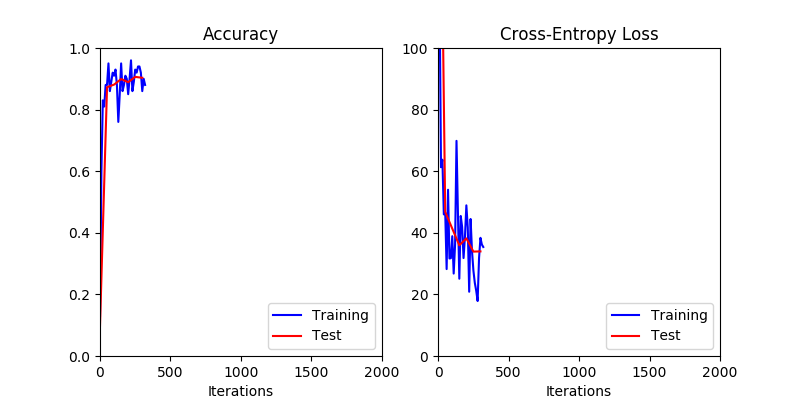

In [4]:
# matplotlib visualisation of accuracy/cost across iterations

def update_line(num, i_train, a_train, c_train, i_test, a_test, c_test):
    l1.set_data(i_train[:num],a_train[:num])
    l3.set_data(i_train[:num],c_train[:num])
    if num % 5 == 0:
        l2.set_data(i_test[:(num/5+1)],a_test[:(num/5+1)])
        l4.set_data(i_test[:(num/5+1)],c_test[:(num/5+1)])
    return l1, l2, l3, l4

fig2, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))

l1, = ax1.plot([], [], 'b-',label='Training')
l2, = ax1.plot([], [], 'r-',label='Test')
ax1.set_xlim(0, 2000)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Iterations')
ax1.set_title('Accuracy')
ax1.legend(loc=4)

l3, = ax2.plot([], [], 'b-',label='Training')
l4, = ax2.plot([], [], 'r-',label='Test')
ax2.set_xlim(0, 2000)
ax2.set_ylim(0, 100)
ax2.set_xlabel('Iterations')
ax2.set_title('Cross-Entropy Loss')
ax2.legend(loc=4)

line_ani = animation.FuncAnimation(fig2, update_line, 201, fargs=(i_train_array, a_train_array, c_train_array, i_test_array, a_test_array, c_test_array),
                                   interval=50, blit=True)


Let's view correct and incorrect predictions on the test data.

<IPython.core.display.Javascript object>


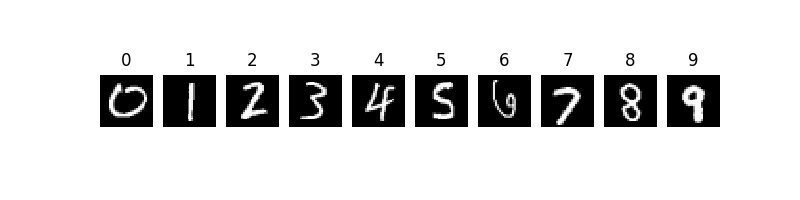

In [5]:
# Run the model again to get predictions on the test data
Y_out, correct = sess.run([Y_pred, correct_prediction], feed_dict={X: mnist.test.images, Y_: mnist.test.labels})

def animate(i,im,data,classes,correct):
    for ind in range(10):
        im[ind].set_data(data[(classes==ind) & correct][i % np.sum([(classes==ind) & correct])].reshape(28,28))
    return im

# Correct predictions (ground truth shown by the title)
fig3 = plt.figure(figsize=(8,2))
im3 = plot_mnist(mnist.test.images, classes=Y_out, correct=correct)

anim3 = animation.FuncAnimation(fig3, animate, frames=1000, fargs=(im3, mnist.test.images, Y_out, correct),
                               interval=1000)

<IPython.core.display.Javascript object>


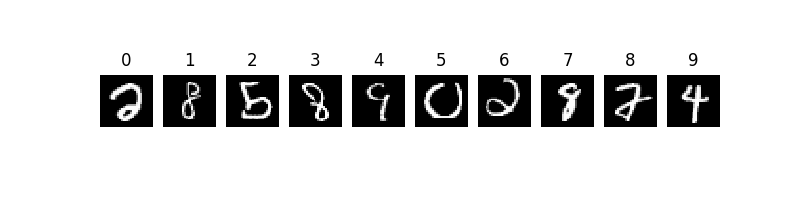

In [6]:
# Incorrect predictions (ground truth shown by the title)                                         
fig4 = plt.figure(figsize=(8,2))
im4 = plot_mnist(mnist.test.images, classes=Y_out, correct=np.invert(correct))

anim4 = animation.FuncAnimation(fig4, animate, frames=1000, fargs=(im4, mnist.test.images, Y_out, np.invert(correct)),
                               interval=1000)

Now we're ready to try out a convolutional neural network to see if we can improve the network's performance. We'll also use a better optimizer (Adam), weight decay, and dropout in the final fully-connected layer.

In [9]:
# neural network structure for this sample:
#
# · · · · · · · · · ·      (input data, 1-deep)                 X [batch, 28, 28, 1]
# @ @ @ @ @ @ @ @ @ @   -- conv. layer 6x6x1=>6 stride 1        W1 [5, 5, 1, 6]        B1 [6]
# ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                           Y1 [batch, 28, 28, 6]
#   @ @ @ @ @ @ @ @     -- conv. layer 5x5x6=>12 stride 2       W2 [5, 5, 6, 12]        B2 [12]
#   ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                             Y2 [batch, 14, 14, 12]
#     @ @ @ @ @ @       -- conv. layer 4x4x12=>24 stride 2      W3 [4, 4, 12, 24]       B3 [24]
#     ∶∶∶∶∶∶∶∶∶∶∶                                               Y3 [batch, 7, 7, 24] => reshaped to YY [batch, 7*7*24]
#      \x/x\x\x/ ✞      -- fully connected layer (relu+dropout) W4 [7*7*24, 200]       B4 [200]
#       · · · ·                                                 Y4 [batch, 200]
#       \x/x\x/         -- fully connected layer (softmax)      W5 [200, 10]           B5 [10]
#        · · ·                                                  Y [batch, 10]

# variable learning rate
lr = tf.placeholder(tf.float32)
# Probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
pkeep = tf.placeholder(tf.float32)

# three convolutional layers with their channel counts, and a
# fully connected layer (the last layer has 10 softmax neurons)
K = 6  # first convolutional layer output depth
L = 12  # second convolutional layer output depth
M = 24  # third convolutional layer
N = 200  # fully connected layer

W1 = tf.Variable(tf.truncated_normal([6, 6, 1, K], stddev=0.1))  # 6x6 patch, 1 input channel, K output channels
B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))
W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1))
B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))
W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1))
B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]))

W4 = tf.Variable(tf.truncated_normal([7 * 7 * M, N], stddev=0.1))
B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]))
W5 = tf.Variable(tf.truncated_normal([N, 10], stddev=0.1))
B5 = tf.Variable(tf.constant(0.1, tf.float32, [10]))

# The model
stride = 1  # output is 28x28
Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
stride = 2  # output is 14x14
Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
stride = 2  # output is 7x7
Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

# reshape the output from the third convolution for the fully connected layer
YY = tf.reshape(Y3, shape=[-1, 7 * 7 * M])

Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
YY4 = tf.nn.dropout(Y4, pkeep)
Ylogits = tf.matmul(YY4, W5) + B5
Y = tf.nn.softmax(Ylogits)

# cross-entropy loss function (= -sum(Y_i * log(Yi)) ), normalised for batches of 100  images
# TensorFlow provides the softmax_cross_entropy_with_logits function to avoid numerical stability
# problems with log(0) which is NaN
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_mean(cross_entropy)*100

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# training step, the learning rate is a placeholder
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)


# init
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


# You can call this function in a loop to train the model, 100 images at a time
def training_step(i, update_test_data, update_train_data):

    # training on batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)

    # learning rate decay
    max_learning_rate = 0.003
    min_learning_rate = 0.0001
    decay_speed = 2000.0
    learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)

    # store train/test accuracy and cost
    a_train = []
    c_train = []
    a_test = []
    c_test = []
    # compute training values for visualisation
    if update_train_data:
        a_train, c_train = sess.run([accuracy, cross_entropy], {X: batch_X, Y_: batch_Y, pkeep: 1.0})
        print(str(i) + ": accuracy:" + str(a_train) + " loss: " + str(c_train) + " (lr:" + str(learning_rate) + ")")

    # compute test values for visualisation
    if update_test_data:
        a_test, c_test = sess.run([accuracy, cross_entropy], {X: mnist.test.images, Y_: mnist.test.labels, pkeep: 1.0})
        print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a_test) + " test loss: " + str(c_test))

    # the backpropagation training step
    sess.run(train_step, {X: batch_X, Y_: batch_Y, lr: learning_rate, pkeep: 0.75})
    
    # NOTE: return only after backpropagation!
    return a_train, c_train, a_test, c_test

# Run for 10000 iterations
i_train_array = []
a_train_array = []
c_train_array = []
i_test_array = []
a_test_array = []
c_test_array = []
for i in range(10000+1):
    a_train, c_train, a_test, c_test = training_step(i, i % 100 == 0, i % 20 == 0)
    if i % 20 == 0:
        i_train_array.append(i)
        a_train_array.append(a_train)
        c_train_array.append(c_train)
    if i % 100 == 0:
        i_test_array.append(i)
        a_test_array.append(a_test)
        c_test_array.append(c_test)

print("max test accuracy: " + str(np.max(a_test_array)))


0: accuracy:0.05 loss: 243.233 (lr:0.003)
0: ********* epoch 1 ********* test accuracy:0.0758 test loss: 246.786
20: accuracy:0.87 loss: 70.1409 (lr:0.00297114451787)
40: accuracy:0.91 loss: 27.4616 (lr:0.00294257615259)
60: accuracy:0.91 loss: 27.6533 (lr:0.00291429204729)
80: accuracy:0.97 loss: 15.3607 (lr:0.00288628937354)
100: accuracy:0.99 loss: 5.73777 (lr:0.00285856533105)
100: ********* epoch 1 ********* test accuracy:0.9527 test loss: 15.2333
120: accuracy:0.99 loss: 5.67933 (lr:0.00283111714739)
140: accuracy:0.98 loss: 8.77958 (lr:0.00280394207773)
160: accuracy:0.96 loss: 9.27847 (lr:0.00277703740452)
180: accuracy:0.98 loss: 5.18424 (lr:0.00275040043729)
200: accuracy:0.96 loss: 15.2732 (lr:0.0027240285123)
200: ********* epoch 1 ********* test accuracy:0.9659 test loss: 10.8139
220: accuracy:0.97 loss: 15.3502 (lr:0.00269791899236)
240: accuracy:0.98 loss: 6.71418 (lr:0.00267206926648)
260: accuracy:0.98 loss: 5.49242 (lr:0.00264647674967)
280: accuracy:0.93 loss: 24.345

2340: accuracy:1.0 loss: 0.210794 (lr:0.00100006412967)
2360: accuracy:0.99 loss: 2.80197 (lr:0.000991108341943)
2380: accuracy:0.98 loss: 6.24048 (lr:0.000982241665793)
2400: accuracy:1.0 loss: 0.326088 (lr:0.000973463214545)
2400: ********* epoch 5 ********* test accuracy:0.99 test loss: 3.17346
2420: accuracy:0.99 loss: 1.88324 (lr:0.000964772110347)
2440: accuracy:1.0 loss: 0.855727 (lr:0.00095616748408)
2460: accuracy:1.0 loss: 0.297437 (lr:0.000947648475274)
2480: accuracy:1.0 loss: 0.1698 (lr:0.000939214232023)
2500: accuracy:1.0 loss: 0.160686 (lr:0.000930863910895)
2500: ********* epoch 5 ********* test accuracy:0.9901 test loss: 3.13063
2520: accuracy:1.0 loss: 0.761301 (lr:0.000922596676849)
2540: accuracy:1.0 loss: 0.942247 (lr:0.000914411703157)
2560: accuracy:1.0 loss: 0.115786 (lr:0.000906308171314)
2580: accuracy:0.99 loss: 2.31088 (lr:0.00089828527096)
2600: accuracy:1.0 loss: 0.623547 (lr:0.000890342199799)
2600: ********* epoch 5 ********* test accuracy:0.9903 test l

4620: accuracy:1.0 loss: 0.0142917 (lr:0.000387857629523)
4640: accuracy:1.0 loss: 0.26141 (lr:0.000384993398253)
4660: accuracy:1.0 loss: 0.157466 (lr:0.00038215766656)
4680: accuracy:1.0 loss: 0.0863988 (lr:0.000379350150868)
4700: accuracy:1.0 loss: 0.0205568 (lr:0.000376570570425)
4700: ********* epoch 8 ********* test accuracy:0.9911 test loss: 3.52894
4720: accuracy:0.99 loss: 1.42303 (lr:0.000373818647269)
4740: accuracy:1.0 loss: 0.604007 (lr:0.000371094106206)
4760: accuracy:1.0 loss: 0.00935455 (lr:0.00036839667478)
4780: accuracy:1.0 loss: 0.495169 (lr:0.000365726083245)
4800: accuracy:1.0 loss: 0.49991 (lr:0.000363082064539)
4800: ********* epoch 9 ********* test accuracy:0.9912 test loss: 3.44494
4820: accuracy:1.0 loss: 0.838179 (lr:0.00036046435426)
4840: accuracy:1.0 loss: 0.220482 (lr:0.000357872690632)
4860: accuracy:1.0 loss: 0.0348038 (lr:0.000355306814489)
4880: accuracy:1.0 loss: 0.0165693 (lr:0.00035276646924)
4900: accuracy:1.0 loss: 0.101871 (lr:0.0003502514008

6900: accuracy:1.0 loss: 0.121567 (lr:0.000192062345496)
6900: ********* epoch 12 ********* test accuracy:0.992 test loss: 3.61073
6920: accuracy:1.0 loss: 0.0389547 (lr:0.000191146309853)
6940: accuracy:1.0 loss: 0.00394473 (lr:0.000190239388917)
6960: accuracy:1.0 loss: 0.025401 (lr:0.000189341491995)
6980: accuracy:1.0 loss: 0.0410053 (lr:0.000188452529297)
7000: accuracy:1.0 loss: 0.305692 (lr:0.000187572411925)
7000: ********* epoch 12 ********* test accuracy:0.9911 test loss: 3.7143
7020: accuracy:1.0 loss: 0.00422432 (lr:0.000186701051867)
7040: accuracy:1.0 loss: 0.0181325 (lr:0.000185838361987)
7060: accuracy:1.0 loss: 0.0257517 (lr:0.000184984256014)
7080: accuracy:1.0 loss: 0.0309706 (lr:0.000184138648538)
7100: accuracy:1.0 loss: 0.0154794 (lr:0.000183301454997)
7100: ********* epoch 12 ********* test accuracy:0.9913 test loss: 3.60728
7120: accuracy:1.0 loss: 0.00478641 (lr:0.000182472591671)
7140: accuracy:1.0 loss: 0.00393683 (lr:0.000181651975673)
7160: accuracy:1.0 los

9140: accuracy:1.0 loss: 0.0161854 (lr:0.000130038083181)
9160: accuracy:1.0 loss: 0.00807035 (lr:0.00012973919926)
9180: accuracy:1.0 loss: 0.0195397 (lr:0.000129443289283)
9200: accuracy:1.0 loss: 0.00535554 (lr:0.000129150323659)
9200: ********* epoch 16 ********* test accuracy:0.9919 test loss: 3.79577
9220: accuracy:1.0 loss: 0.00591788 (lr:0.000128860273093)
9240: accuracy:1.0 loss: 0.0178503 (lr:0.000128573108577)
9260: accuracy:1.0 loss: 0.0134816 (lr:0.000128288801397)
9280: accuracy:1.0 loss: 0.0172642 (lr:0.00012800732312)
9300: accuracy:1.0 loss: 0.00390011 (lr:0.000127728645599)
9300: ********* epoch 16 ********* test accuracy:0.9916 test loss: 3.83034
9320: accuracy:1.0 loss: 0.0121303 (lr:0.000127452740965)
9340: accuracy:1.0 loss: 0.000374299 (lr:0.000127179581628)
9360: accuracy:1.0 loss: 0.00196963 (lr:0.000126909140272)
9380: accuracy:1.0 loss: 0.0276376 (lr:0.000126641389853)
9400: accuracy:1.0 loss: 0.00314082 (lr:0.000126376303595)
9400: ********* epoch 16 *******

Let's visualize the accuracy and cross-entropy loss like we did before. With a convolutional neural network, we now reach an accuracy > 99%!

<IPython.core.display.Javascript object>


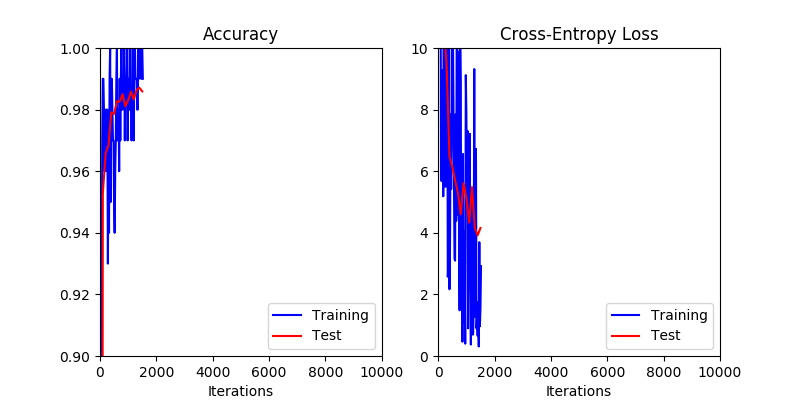

In [10]:
fig5, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))

l1, = ax1.plot([], [], 'b-',label='Training')
l2, = ax1.plot([], [], 'r-',label='Test')
ax1.set_xlim(0, 10000)
ax1.set_ylim(0.9, 1)
ax1.set_xlabel('Iterations')
ax1.set_title('Accuracy')
ax1.legend(loc=4)

l3, = ax2.plot([], [], 'b-',label='Training')
l4, = ax2.plot([], [], 'r-',label='Test')
ax2.set_xlim(0, 10000)
ax2.set_ylim(0, 10)
ax2.set_xlabel('Iterations')
ax2.set_title('Cross-Entropy Loss')
ax2.legend(loc=4)

line_ani = animation.FuncAnimation(fig5, update_line, 501, fargs=(i_train_array, a_train_array, c_train_array, i_test_array, a_test_array, c_test_array),
                                   interval=50, blit=True)